# Análise dos Impactos Socioeconômicos do Desmatamento no Pará: Preparação dos Dados e Análise Preliminar

Este notebook documenta o processo de carga, limpeza, transformação, fusão de dados e uma análise exploratória inicial para investigar os impactos socioeconômicos do desmatamento no estado do Pará. As bases de dados utilizadas incluem informações sobre desmatamento (PRODES), Produto Interno Bruto (PIB) dos municípios, produção da extração vegetal e indicadores de governança (CGU).

## Escolha de dados

O passo zero foi justamente pela escolha de dados para o desenvolvimento do desafio, através de bases como `Base de Dados`, `INPE`, ``IBGE``, `dados.gov`, entre outras.

Muitos desses dados possuem boa qualidade e especificidade para a proposta do desafio, desse modo a execução de determinadas tarefas torna-se mais simples. Ainda sim, para facilitar o entendimento, manipulação e compreensão dos dados, foram utilizadas ferramentas para a conversão do Raw data adquirido através das bases de dados supracitadas, visando a manipulação através do *`DBeaver`*, ferramenta que melhor permite manipular dados através da linguagem SQL.

In [ ]:
"""
Abaixo encontram-se os códigos para descompactar os arquivos .gz
Os arquivos .gz foram baixados do portal de dados abertos do governo federal.

import gzip
import shutil

def descompacta_gz(arquivo_gz, arquivo_descompactado):
  with gzip.open(arquivo_gz, 'rb') as f_in:
    with open(arquivo_descompactado, 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)

descompacta_gz('/content/br_cgu_ebt_municipio.csv.gz', 'cgu.csv')
descompacta_gz('/content/br_ibge_pib_uf.csv.gz', 'pib_uf.csv')
descompacta_gz('/content/br_ibge_pevs_producao_extracao_vegetal.csv.gz', 'producao_extracao_vegetal.csv')
descompacta_gz('/content/br_ibge_pib_municipio.csv.gz', 'pib_municipios.csv')
descompacta_gz('/content/br_inpe_prodes_municipio_bioma.csv.gz', 'prodes_bioma.csv')

"""

O processo exemplificado abaixo foi para a criação do banco de dados sqlite, no entanto ele foi feito em partes através da ferramente do Google Colab, principalmente devido a limitações da minha máquina pessoal. Justamente devido à isso que ele se encontra comentado.

In [ ]:
"""

import os
import pandas as pd
import sqlite3

# Caminho onde estão os CSVs
caminho_pasta = '/content'  # substitua pelo caminho da sua pasta local ou do Colab

# Lista todos os arquivos .csv da pasta
csvs = [f for f in os.listdir(caminho_pasta) if f.endswith('.csv')]

print("Arquivos CSV encontrados:", csvs)

# Cria o banco SQLite
conn = sqlite3.connect('meu_banco.db')

for arquivo in csvs:
    caminho_arquivo = os.path.join(caminho_pasta, arquivo)
    nome_tabela = os.path.splitext(arquivo)[0]  # nome da tabela = nome do arquivo

    # Lê o CSV
    df = pd.read_csv(caminho_arquivo)

    # Salva no SQLite
    df.to_sql(nome_tabela, conn, if_exists='replace', index=False)
    print(f"Tabela '{nome_tabela}' criada com sucesso!")
    
"""


## 1. Importação das Bibliotecas Necessárias

Iniciamos importando as bibliotecas Python que serão utilizadas ao longo do processo: `sqlite3` para interagir com o banco de dados, `pandas` para manipulação e análise de dados, `matplotlib` e `seaborn` para visualizações, e `numpy` para operações numéricas.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para melhor visualização no pandas e matplotlib
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
plt.style.use("ggplot")

# Para exibir os gráficos diretamente no notebook
%matplotlib inline

## 2. Carga dos Dados

Nesta seção, conectamos ao banco de dados SQLite fornecido (`meu_banco.db`) e carregamos as tabelas relevantes para a análise. As tabelas são:

- `prodes_bioma`: Dados de desmatamento.
- `pib_municipios`: Dados do PIB dos municípios.
- `producao_extracao_vegetal`: Dados sobre a produção da extração vegetal.
- `cgu`: Dados da Controladoria-Geral da União (CGU) sobre indicadores de governança.
- `pib_uf`: Dados do PIB por Unidade da Federação, utilizados para identificar o código do estado do Pará.

In [5]:
# Caminho para o banco de dados
db_path = "./meu_banco.db"

# Conectar ao banco de dados
conn = sqlite3.connect(db_path)

# Obter o id_uf para o Pará (PA) para filtragem posterior
df_pib_uf = pd.read_sql_query(
    "SELECT id_uf, sigla_uf FROM pib_uf WHERE sigla_uf = 'PA'", conn)
id_para = None
if not df_pib_uf.empty:
    id_para = df_pib_uf["id_uf"].iloc[0]
    print(f"ID UF para o Pará (PA) encontrado: {id_para}")
else:
    print("ID UF para o Pará (PA) não encontrado na tabela 'pib_uf'. Utilizando 15 como padrão (código IBGE comum para o Pará).")
    id_para = 15 # Código IBGE para o Pará é 15

# Carregar as tabelas relevantes
df_prodes = pd.read_sql_query("SELECT * FROM prodes_bioma", conn)
print(f"Tabela 'prodes_bioma' carregada: {df_prodes.shape[0]} linhas, {df_prodes.shape[1]} colunas")
display(df_prodes.head())

df_pib_municipios = pd.read_sql_query("SELECT * FROM pib_municipios", conn)
print(f"Tabela 'pib_municipios' carregada: {df_pib_municipios.shape[0]} linhas, {df_pib_municipios.shape[1]} colunas")
display(df_pib_municipios.head())

df_extracao_vegetal = pd.read_sql_query("SELECT * FROM producao_extracao_vegetal", conn)
print(f"Tabela 'producao_extracao_vegetal' carregada: {df_extracao_vegetal.shape[0]} linhas, {df_extracao_vegetal.shape[1]} colunas")
display(df_extracao_vegetal.head())

df_cgu = pd.read_sql_query("SELECT * FROM cgu", conn)
print(f"Tabela 'cgu' carregada: {df_cgu.shape[0]} linhas, {df_cgu.shape[1]} colunas")
display(df_cgu.head())

# Fechar a conexão com o banco de dados
conn.close()
print("Carga de dados concluída.")

ID UF para o Pará (PA) encontrado: 15
Tabela 'prodes_bioma' carregada: 156864 linhas, 8 colunas


,ano,id_municipio,bioma,area_total,desmatado,vegetacao_natural,nao_vegetacao_natural,hidrografia
0,2009,5102504,Pantanal,17422.29079,3124.8,12616.5,0.4,1680.6
1,2011,5102504,Pantanal,17422.29079,3203.4,12537.9,0.4,1680.6
2,2010,5102504,Pantanal,17422.29079,3157.8,12583.5,0.4,1680.6
3,2005,5102504,Pantanal,17422.29079,2937.1,12804.2,0.4,1680.6
4,2002,5102504,Pantanal,17422.29079,2598.0,13143.3,0.4,1680.6


Tabela 'pib_municipios' carregada: 111400 linhas, 9 colunas


,id_municipio,ano,pib,impostos_liquidos,va,va_agropecuaria,va_industria,va_servicos,va_adespss
0,1200500,2002,125410.0,2474.0,122936.0,42357.0,8335.0,20708.0,51537.0
1,1300300,2002,76039.0,1632.0,74407.0,34073.0,3678.0,8944.0,27712.0
2,1302108,2002,13798.0,324.0,13474.0,1568.0,388.0,1203.0,10315.0
3,1400175,2002,38787.0,918.0,37868.0,4671.0,2536.0,4567.0,26095.0
4,1502400,2002,498849.0,58905.0,439944.0,18100.0,80539.0,239642.0,101663.0


Tabela 'producao_extracao_vegetal' carregada: 443478 linhas, 7 colunas


,ano,id_municipio,tipo_produto,produto,unidade,quantidade,valor
0,1994,1600402,None,Lenha,Metros cúbicos,16822,232.0
1,1994,1707652,None,Lenha,Metros cúbicos,13500,34.0
2,1994,1709005,None,Lenha,Metros cúbicos,54000,119.0
3,1994,2106201,None,Lenha,Metros cúbicos,16500,57.0
4,1994,2405702,None,Lenha,Metros cúbicos,126300,253.0


Tabela 'cgu' carregada: 1330 linhas, 5 colunas


,ano,sigla_uf,id_municipio,ranking,nota
0,2020,ES,3205002,1,9.95
1,2020,PR,4113700,1,9.95
2,2020,PA,1505304,3,9.92
3,2020,PE,2611606,4,9.90
4,2020,ES,3205309,5,9.85


Carga de dados concluída.


## 3. Filtragem dos Dados para o Estado do Pará

O foco da análise é o estado do Pará. Portanto, filtramos os DataFrames para incluir apenas os dados referentes aos municípios paraenses. A filtragem é feita utilizando o `id_municipio` (que geralmente inicia com o código do estado, 15 para o Pará) ou a `sigla_uf` quando disponível.

In [9]:
print("Iniciando a filtragem dos dados para o Estado do Pará...")

# Filtrar df_prodes para o Pará
df_prodes_pa = df_prodes[df_prodes["id_municipio"].astype(str).str.startswith(str(id_para))].copy()
print(f"'prodes_bioma' filtrado para o Pará: {df_prodes_pa.shape[0]} linhas")
#display(df_prodes_pa.head())

# Filtrar df_pib_municipios para o Pará
df_pib_municipios_pa = df_pib_municipios[df_pib_municipios["id_municipio"].astype(str).str.startswith(str(id_para))].copy()
print(f"'pib_municipios' filtrado para o Pará: {df_pib_municipios_pa.shape[0]} linhas")
#display(df_pib_municipios_pa.head())

# Filtrar df_extracao_vegetal para o Pará
df_extracao_vegetal_pa = df_extracao_vegetal[df_extracao_vegetal["id_municipio"].astype(str).str.startswith(str(id_para))].copy()
print(f"'producao_extracao_vegetal' filtrado para o Pará: {df_extracao_vegetal_pa.shape[0]} linhas")
#display(df_extracao_vegetal_pa.head())

# Filtrar df_cgu para o Pará
df_cgu_pa = df_cgu[df_cgu["sigla_uf"] == "PA"].copy()
print(f"'cgu' filtrado para o Pará: {df_cgu_pa.shape[0]} linhas")
#display(df_cgu_pa.head())

print("Filtragem de dados para o Pará concluída.")

Iniciando a filtragem dos dados para o Estado do Pará...
'prodes_bioma' filtrado para o Pará: 3624 linhas
'pib_municipios' filtrado para o Pará: 2880 linhas
'producao_extracao_vegetal' filtrado para o Pará: 22094 linhas
'cgu' filtrado para o Pará: 90 linhas
Filtragem de dados para o Pará concluída.


## 4. Limpeza e Transformação dos Dados

Esta é uma etapa crucial para garantir a qualidade dos dados. Realizamos as seguintes operações:

- **Conversão de Tipos**: Convertemos colunas relevantes para o tipo numérico, tratando possíveis erros de conversão (valores não numéricos são convertidos para `NaN`).
- **Tratamento de Valores Ausentes (`NaN`)**: Para colunas chave (`ano`, `id_municipio`) e métricas principais (ex: `desmatado`, `pib`, `nota`), removemos linhas onde esses valores são ausentes. Para outras colunas, como `tipo_produto`, preenchemos `NaN` com 'Não especificado'. A estratégia de tratamento de `NaN` pode variar (remoção, preenchimento com média/mediana/moda, etc.) dependendo do contexto e da quantidade de dados ausentes.
- **Verificação de Consistência**: Asseguramos que a coluna `ano` seja do tipo inteiro após a limpeza.

In [10]:
print("Iniciando a limpeza e transformação dos dados...")

# Função auxiliar para converter colunas para numérico e tratar erros de conversão
def convert_to_numeric_and_clean(df, column_name, fill_na_value=None):
    df[column_name] = pd.to_numeric(df[column_name], errors="coerce")
    if fill_na_value is not None:
        df[column_name].fillna(fill_na_value, inplace=True)
    return df

# Limpeza df_prodes_pa
print("Limpando 'df_prodes_pa'...")
df_prodes_pa = convert_to_numeric_and_clean(df_prodes_pa, "ano")
df_prodes_pa = convert_to_numeric_and_clean(df_prodes_pa, "desmatado")
df_prodes_pa = convert_to_numeric_and_clean(df_prodes_pa, "area_total")
df_prodes_pa.dropna(subset=["ano", "id_municipio", "desmatado"], inplace=True)
df_prodes_pa["ano"] = df_prodes_pa["ano"].astype(int)
print(f"'df_prodes_pa' após limpeza: {df_prodes_pa.shape[0]} linhas.")
#display(df_prodes_pa.head())

# Limpeza df_pib_municipios_pa
print("Limpando 'df_pib_municipios_pa'...")
pib_cols_to_convert = ["pib", "impostos_liquidos", "va", "va_agropecuaria", "va_industria", "va_servicos", "va_adespss"]
for col in pib_cols_to_convert:
    df_pib_municipios_pa = convert_to_numeric_and_clean(df_pib_municipios_pa, col)
df_pib_municipios_pa = convert_to_numeric_and_clean(df_pib_municipios_pa, "ano")
df_pib_municipios_pa.dropna(subset=["ano", "id_municipio", "pib"], inplace=True)
df_pib_municipios_pa["ano"] = df_pib_municipios_pa["ano"].astype(int)
print(f"'df_pib_municipios_pa' após limpeza: {df_pib_municipios_pa.shape[0]} linhas.")
#display(df_pib_municipios_pa.head())

# Limpeza df_extracao_vegetal_pa
print("Limpando 'df_extracao_vegetal_pa'...")
df_extracao_vegetal_pa = convert_to_numeric_and_clean(df_extracao_vegetal_pa, "quantidade")
df_extracao_vegetal_pa = convert_to_numeric_and_clean(df_extracao_vegetal_pa, "valor")
df_extracao_vegetal_pa = convert_to_numeric_and_clean(df_extracao_vegetal_pa, "ano")
df_extracao_vegetal_pa["tipo_produto"].fillna("Não especificado", inplace=True)
df_extracao_vegetal_pa.dropna(subset=["ano", "id_municipio", "valor"], inplace=True)
df_extracao_vegetal_pa["ano"] = df_extracao_vegetal_pa["ano"].astype(int)
print(f"'df_extracao_vegetal_pa' após limpeza: {df_extracao_vegetal_pa.shape[0]} linhas.")
#display(df_extracao_vegetal_pa.head())

# Limpeza df_cgu_pa
print("Limpando 'df_cgu_pa'...")
df_cgu_pa = convert_to_numeric_and_clean(df_cgu_pa, "nota")
df_cgu_pa = convert_to_numeric_and_clean(df_cgu_pa, "ranking")
df_cgu_pa = convert_to_numeric_and_clean(df_cgu_pa, "ano")
df_cgu_pa.dropna(subset=["ano", "id_municipio", "nota"], inplace=True)
df_cgu_pa["ano"] = df_cgu_pa["ano"].astype(int)
print(f"'df_cgu_pa' após limpeza: {df_cgu_pa.shape[0]} linhas.")
#display(df_cgu_pa.head())

print("Limpeza e transformação de dados concluída.")

Iniciando a limpeza e transformação dos dados...
Limpando 'df_prodes_pa'...
'df_prodes_pa' após limpeza: 3624 linhas.
Limpando 'df_pib_municipios_pa'...
'df_pib_municipios_pa' após limpeza: 2869 linhas.
Limpando 'df_extracao_vegetal_pa'...
'df_extracao_vegetal_pa' após limpeza: 22094 linhas.
Limpando 'df_cgu_pa'...
'df_cgu_pa' após limpeza: 90 linhas.
Limpeza e transformação de dados concluída.


C:\Users\gusta\AppData\Local\Temp\ipykernel_34232\3829411310.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_extracao_vegetal_pa["tipo_produto"].fillna("Não especificado", inplace=True)


## 5. Fusão dos Dados (Merge)

Após a limpeza, unimos os diferentes DataFrames para criar um conjunto de dados consolidado. A fusão é realizada utilizando `id_municipio` e `ano` como chaves comuns.

- **PRODES e PIB**: Unimos os dados de desmatamento com os dados do PIB municipal usando um `inner merge`. Isso significa que apenas os municípios e anos presentes em ambas as tabelas serão mantidos.
- **CGU**: Adicionamos os dados de governança da CGU ao DataFrame resultante usando um `left merge`. Isso mantém todos os registros do merge anterior (PRODES e PIB) e adiciona os dados da CGU onde houver correspondência. Se não houver dados da CGU para um determinado município/ano, os campos correspondentes ficarão como `NaN`.
- **Extração Vegetal**: Para incorporar os dados de extração vegetal, que possuem uma granularidade diferente (múltiplos produtos por município/ano), agregamos o `valor` total da produção por `id_municipio` e `ano` antes de realizar um `left merge`.

In [11]:
print("Iniciando a fusão dos dados...")

# Merge Prodes com PIB (inner merge para garantir que temos dados de ambos para a análise inicial)
df_merged = pd.merge(df_prodes_pa, df_pib_municipios_pa, on=["id_municipio", "ano"], how="inner")
print(f"Após merge Prodes e PIB: {df_merged.shape[0]} linhas")

# Merge com CGU (left merge para não perder dados do merge anterior se não houver correspondência em CGU)
df_merged = pd.merge(df_merged, df_cgu_pa[["id_municipio", "ano", "nota", "ranking"]], on=["id_municipio", "ano"], how="left")
print(f"Após merge com CGU: {df_merged.shape[0]} linhas")

# Agregar dados de Extração Vegetal (soma do valor por ano/município)
df_extracao_agg = df_extracao_vegetal_pa.groupby(["id_municipio", "ano"])["valor"].sum().reset_index()
df_extracao_agg.rename(columns={"valor": "valor_extracao_vegetal_total"}, inplace=True)
df_merged = pd.merge(df_merged, df_extracao_agg, on=["id_municipio", "ano"], how="left")
print(f"Após merge com Extração Vegetal (agregado): {df_merged.shape[0]} linhas")

print("Fusão de dados concluída.")
print("DataFrame final 'df_merged' pronto para análise: " + f"{df_merged.shape[0]} linhas, {df_merged.shape[1]} colunas.")
print(f"Colunas: {df_merged.columns.tolist()}")

#display(df_merged.head())
#df_merged.info()
#display(df_merged.isnull().sum())


Iniciando a fusão dos dados...
Após merge Prodes e PIB: 3009 linhas
Após merge com CGU: 3009 linhas
Após merge com Extração Vegetal (agregado): 3009 linhas
Fusão de dados concluída.
DataFrame final 'df_merged' pronto para análise: 3009 linhas, 18 colunas.
Colunas: ['ano', 'id_municipio', 'bioma', 'area_total', 'desmatado', 'vegetacao_natural', 'nao_vegetacao_natural', 'hidrografia', 'pib', 'impostos_liquidos', 'va', 'va_agropecuaria', 'va_industria', 'va_servicos', 'va_adespss', 'nota', 'ranking', 'valor_extracao_vegetal_total']


## 6. Análise Exploratória Inicial e Visualizações

Com os dados preparados, podemos iniciar uma análise exploratória para entender melhor as distribuições, correlações e possíveis padrões. Esta seção incluirá estatísticas descritivas e algumas visualizações básicas.

Estatísticas Descritivas do DataFrame Final:


,ano,id_municipio,area_total,desmatado,vegetacao_natural,nao_vegetacao_natural,hidrografia,pib,impostos_liquidos,va,va_agropecuaria,va_industria,va_servicos,va_adespss,nota,ranking,valor_extracao_vegetal_total
count,3009.000000,3.009000e+03,3009.000000,3009.000000,3009.000000,3009.000000,3009.000000,3.009000e+03,3.009000e+03,3.009000e+03,3.009000e+03,3.009000e+03,3.009000e+03,3.009000e+03,94.000000,94.000000,2926.000000
mean,2011.516451,1.504506e+06,8261.477883,1648.459355,5889.950947,447.332669,275.733732,7.275360e+05,6.626810e+04,6.612679e+05,7.538176e+04,2.205677e+05,2.328633e+05,1.324550e+05,6.661277,332.329787,9543.616883
std,5.768167,2.396202e+03,19090.403113,2151.462441,17212.329405,1077.830738,563.690181,2.702323e+06,3.288100e+05,2.433412e+06,9.978059e+04,1.456672e+06,1.141830e+06,3.225617e+05,1.606121,164.888714,22980.317107
min,2002.000000,1.500107e+06,101.779740,0.000000,-4.500000,0.000000,0.000000,1.102800e+04,2.350000e+02,1.070400e+04,1.221000e+03,-6.273000e+03,1.389000e+03,3.722000e+03,2.690000,3.000000,1.000000
25%,2007.000000,1.502608e+06,916.620610,314.300000,181.200000,0.100000,1.000000,8.040300e+04,2.214000e+03,7.753400e+04,2.051000e+04,3.682000e+03,1.344400e+04,2.955600e+04,5.920000,231.500000,270.250000
50%,2012.000000,1.504752e+06,2820.204690,946.000000,702.900000,13.200000,36.300000,1.970050e+05,7.567000e+03,1.873520e+05,4.411600e+04,1.102900e+04,3.741000e+04,6.354900e+04,6.385000,350.000000,2007.500000
75%,2017.000000,1.506500e+06,7171.608270,2236.400000,4024.900000,189.400000,291.600000,4.634050e+05,2.707000e+04,4.287820e+05,8.788800e+04,4.995700e+04,1.053600e+05,1.307420e+05,7.730000,421.750000,8280.000000
max,2021.000000,1.508407e+06,159482.273990,20450.400000,150656.400000,5333.800000,3830.300000,4.976304e+07,6.341813e+06,4.835668e+07,1.376072e+06,4.065967e+07,1.806130e+07,5.719640e+06,9.950000,656.000000,286997.000000


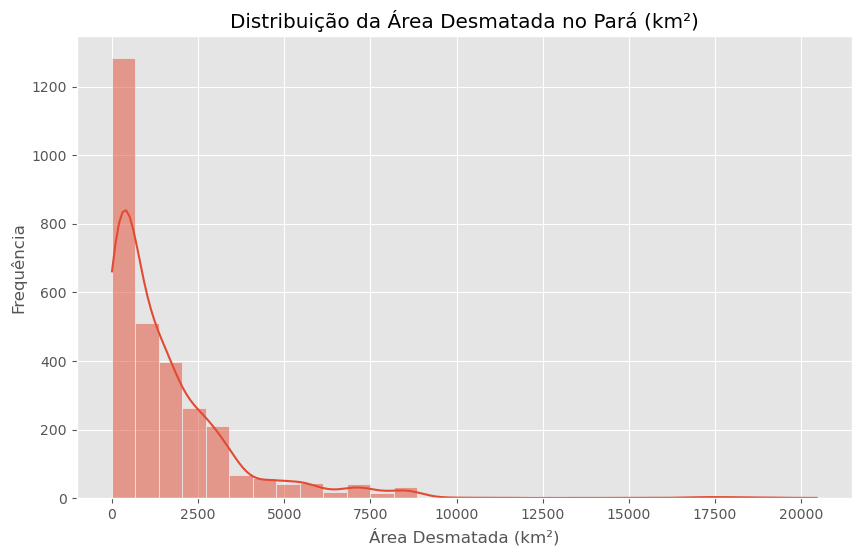

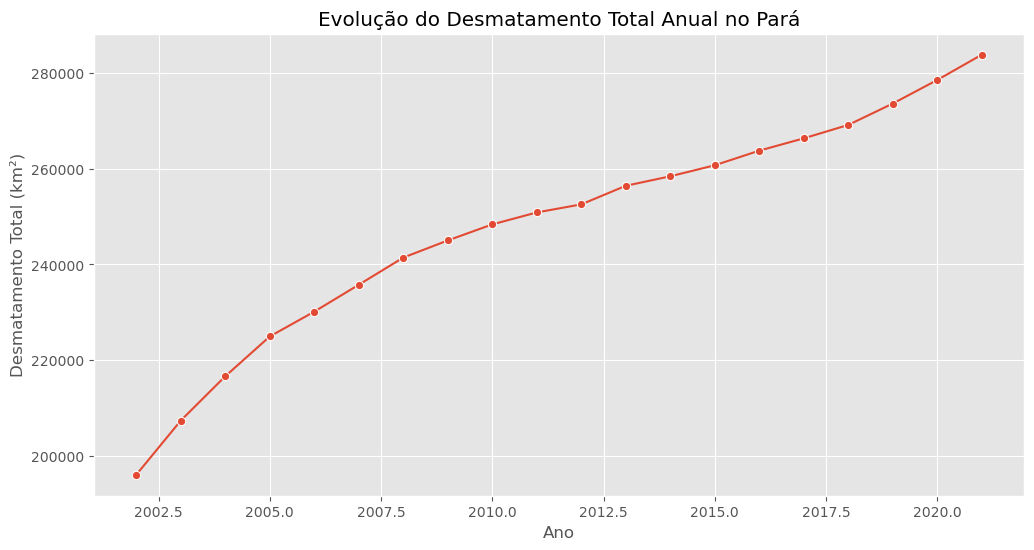

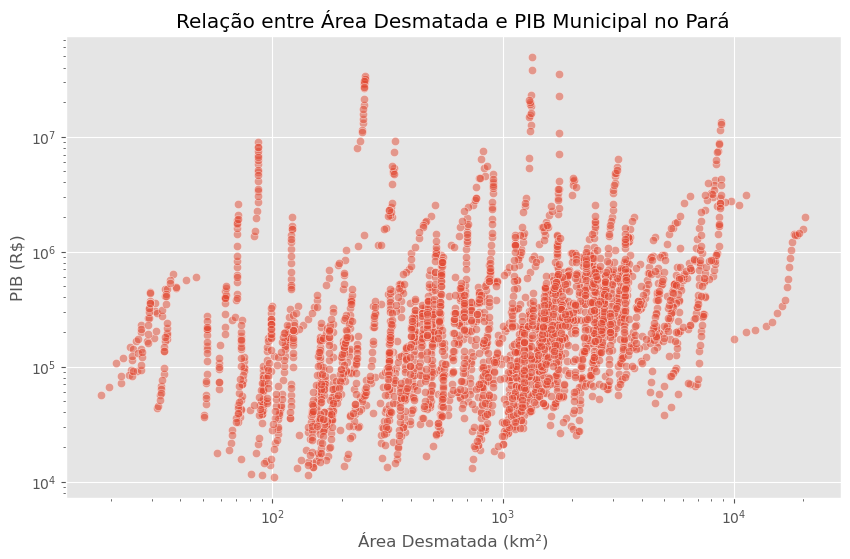

In [21]:
print("Estatísticas Descritivas do DataFrame Final:")
display(df_merged.describe())

# Visualização da distribuição da área desmatada
plt.figure(figsize=(10, 6))
sns.histplot(df_merged["desmatado"].dropna(), kde=True, bins=30)
plt.title("Distribuição da Área Desmatada no Pará (km²)")
plt.xlabel("Área Desmatada (km²)")
plt.ylabel("Frequência")
plt.savefig("./outputs/dist_desmatamento.png")
plt.show() # Comentado para execução em lote
plt.close()

# Visualização da evolução do desmatamento ao longo dos anos
desmatamento_anual = df_merged.groupby("ano")["desmatado"].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x="ano", y="desmatado", data=desmatamento_anual, marker="o")
plt.title("Evolução do Desmatamento Total Anual no Pará")
plt.xlabel("Ano")
plt.ylabel("Desmatamento Total (km²)")
plt.grid(True)
plt.savefig("./outputs/evolucao_desmatamento.png")
plt.show()
plt.close()

# Visualização da relação entre Desmatamento e PIB
plt.figure(figsize=(10, 6))
sns.scatterplot(x="desmatado", y="pib", data=df_merged, alpha=0.5)
plt.title("Relação entre Área Desmatada e PIB Municipal no Pará")
plt.xlabel("Área Desmatada (km²)")
plt.ylabel("PIB (R$)")
plt.xscale("log") # Usar escala logarítmica devido à dispersão dos dados de desmatamento e PIB
plt.yscale("log")
plt.savefig("./outputs/desmatamento_pib.png")
plt.show()
plt.close()

### 7.1. Análise Temporal Detalhada: Desmatamento e Setores do PIB

Vamos analisar a evolução do desmatamento em conjunto com a evolução dos principais setores do PIB (Agropecuária, Indústria, Serviços) para o estado do Pará como um todo. Isso pode nos dar uma visão macro das tendências.

,ano,desmatado_total_km2,pib_total,va_agropecuaria_total,va_industria_total,va_servicos_total,valor_extracao_total,nota_cgu_media
0,2002,196074.3,27233825.0,3630834.0,6299088.0,9488172.0,1243901.0,NaN
1,2003,207390.3,31177057.0,4264038.0,7117208.0,10665272.0,1311717.0,NaN
2,2004,216653.9,38357693.0,4502453.0,9911205.0,13890650.0,1138023.0,NaN
3,2005,224966.0,41698315.0,4919785.0,10298391.0,14947542.0,1202174.0,NaN
4,2006,230148.9,47282002.0,5372929.0,11625671.0,17357722.0,1296058.0,NaN


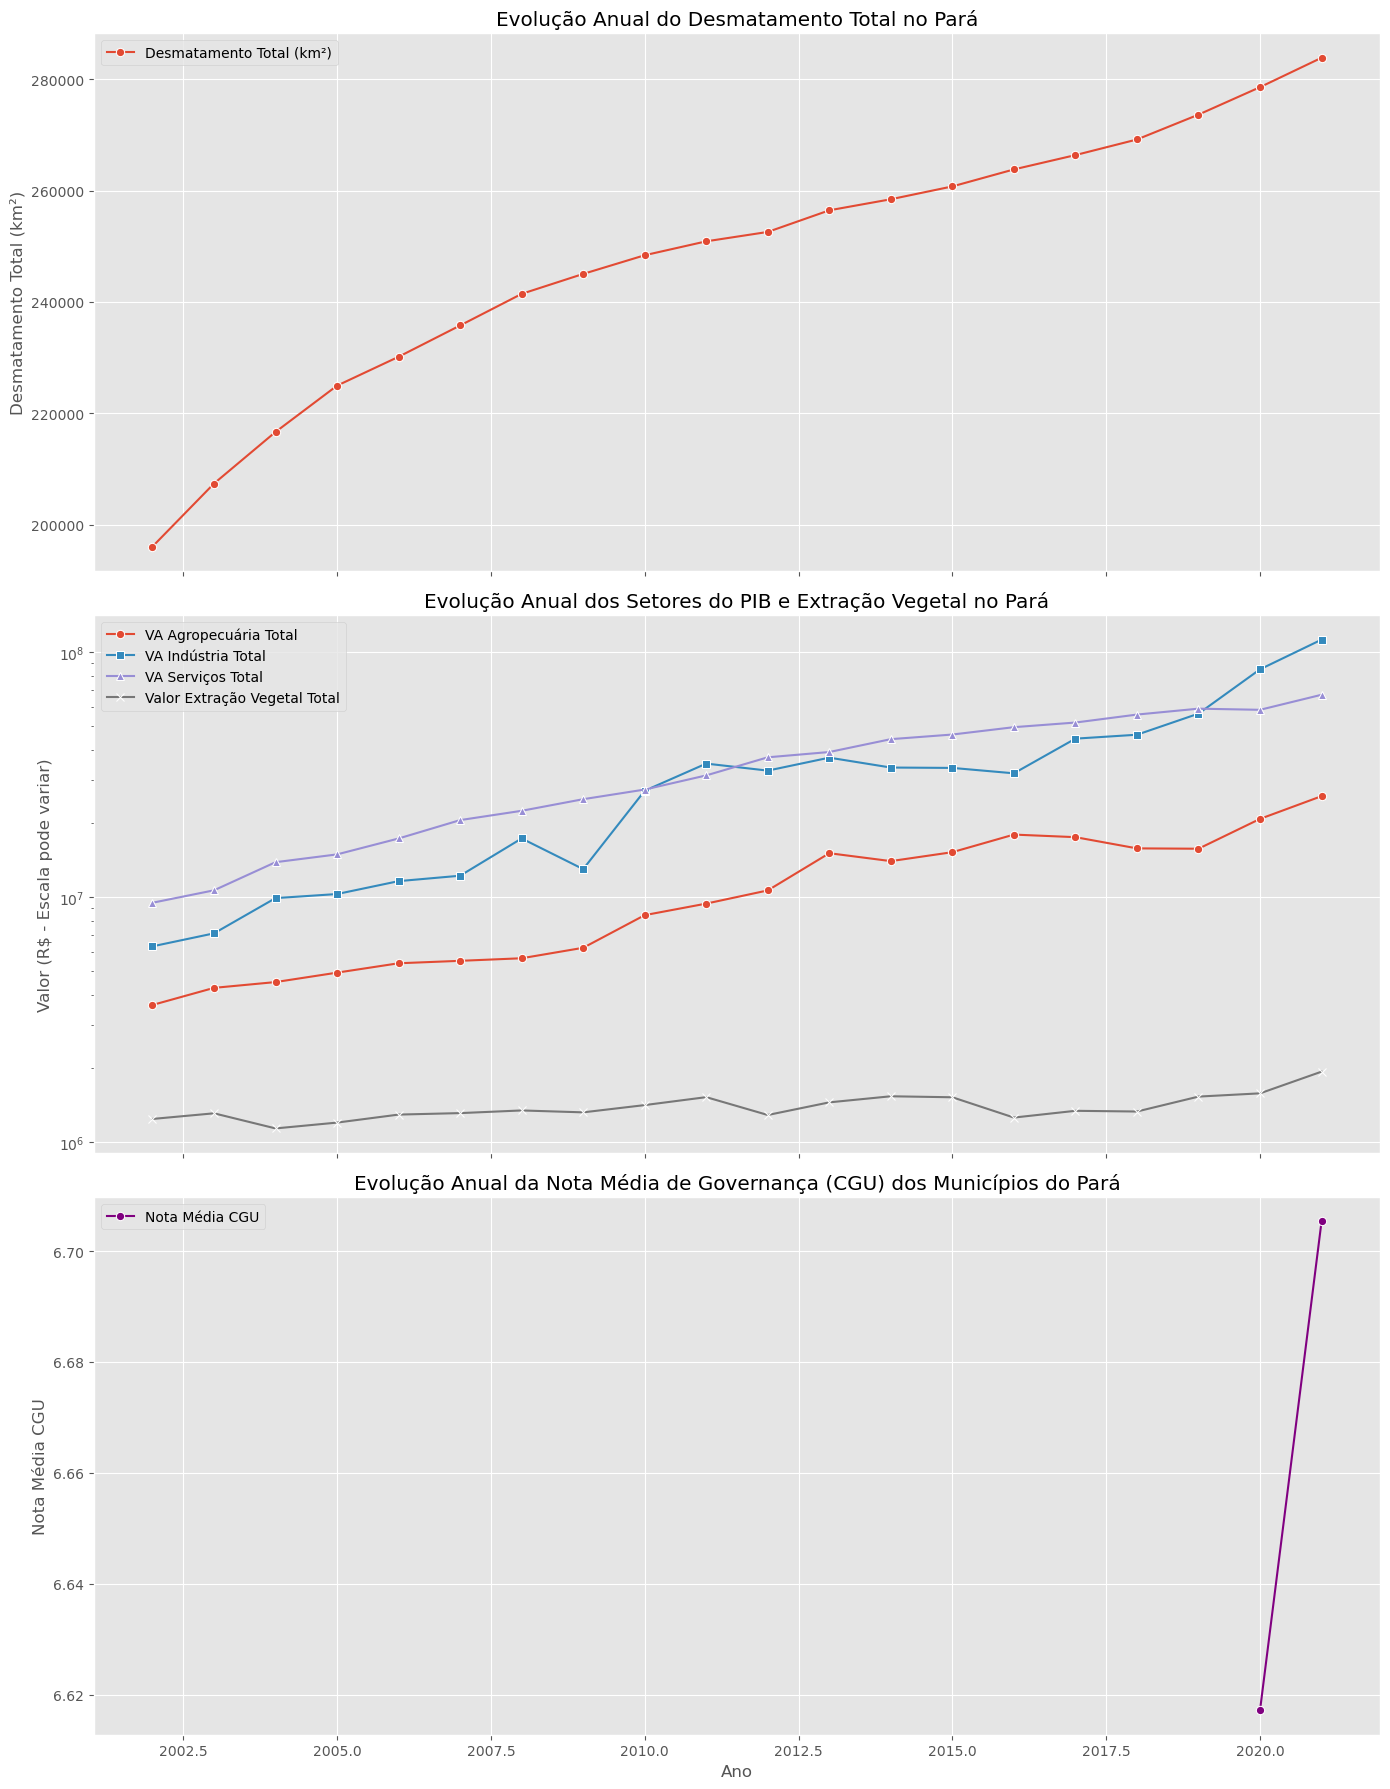

Gráficos de evolução temporal detalhada gerados e salvos.


In [22]:
# Agregar dados por ano para o estado do Pará
df_para_anual = df_merged.groupby("ano").agg(
    desmatado_total_km2=("desmatado", "sum"),
    pib_total=("pib", "sum"),
    va_agropecuaria_total=("va_agropecuaria", "sum"),
    va_industria_total=("va_industria", "sum"),
    va_servicos_total=("va_servicos", "sum"),
    valor_extracao_total=("valor_extracao_vegetal_total", "sum"),
    nota_cgu_media=("nota", "mean")
).reset_index()

display(df_para_anual.head())

# Criar gráficos de evolução temporal
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Gráfico 1: Desmatamento Total Anual
sns.lineplot(x="ano", y="desmatado_total_km2", data=df_para_anual, ax=axs[0], marker="o", label="Desmatamento Total (km²)")
axs[0].set_title("Evolução Anual do Desmatamento Total no Pará")
axs[0].set_ylabel("Desmatamento Total (km²)")
axs[0].legend()
axs[0].grid(True)

# Gráfico 2: Evolução dos Setores do PIB e Valor da Extração Vegetal
sns.lineplot(x="ano", y="va_agropecuaria_total", data=df_para_anual, ax=axs[1], marker="o", label="VA Agropecuária Total")
sns.lineplot(x="ano", y="va_industria_total", data=df_para_anual, ax=axs[1], marker="s", label="VA Indústria Total")
sns.lineplot(x="ano", y="va_servicos_total", data=df_para_anual, ax=axs[1], marker="^", label="VA Serviços Total")
sns.lineplot(x="ano", y="valor_extracao_total", data=df_para_anual, ax=axs[1], marker="x", label="Valor Extração Vegetal Total")
axs[1].set_title("Evolução Anual dos Setores do PIB e Extração Vegetal no Pará")
axs[1].set_ylabel("Valor (R$ - Escala pode variar)")
axs[1].legend()
axs[1].grid(True)
axs[1].set_yscale("log")

# Gráfico 3: Evolução da Nota Média da CGU
sns.lineplot(x="ano", y="nota_cgu_media", data=df_para_anual, ax=axs[2], marker="o", label="Nota Média CGU", color="purple")
axs[2].set_title("Evolução Anual da Nota Média de Governança (CGU) dos Municípios do Pará")
axs[2].set_ylabel("Nota Média CGU")
axs[2].set_xlabel("Ano")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.savefig("./outputs/evolucao_temporal_detalhada.png")
plt.show()
plt.close()

print("Gráficos de evolução temporal detalhada gerados e salvos.")

### ANÁLISES DETALHADAS ENCONTRAM-SE NO PDF DO DESAFIO

## 8. Salvando o DataFrame Processado

Para facilitar análises futuras e a criação do dashboard, salvamos o DataFrame processado e mesclado em um arquivo CSV.

In [25]:
output_csv_path = ".\outputs\dados_analise_desmatamento_pa.csv"
df_merged.to_csv(output_csv_path, index=False, encoding="utf-8")
print(f"DataFrame processado salvo em: {output_csv_path}")

DataFrame processado salvo em: .\outputs\dados_analise_desmatamento_pa.csv


<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\gusta\AppData\Local\Temp\ipykernel_34232\184077948.py:1: SyntaxWarning: invalid escape sequence '\o'
  output_csv_path = ".\outputs\dados_analise_desmatamento_pa.csv"
